### Разведывательный анализ данных для модели   
### "Предсказание результатов госэкзамена по математике для учеников школ"

Цель данной программы подготовить данные для предсказательной модели: найти пустые значения, удалить выбросы, определить какие столбцы могут влиять на итоговую оценку.

Необходимые приготовления:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from itertools import filterfalse
from scipy.stats import ttest_ind
%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

Загрузим файл и посмотрим, что в нем

In [3]:
students = pd.read_csv('stud_math.csv')

In [4]:
students.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [5]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Мы видим, что названия колонок имеют разный регистр, поправим это:

In [6]:
students.columns = students.columns.str.lower()
students.head(2)

,school,sex,age,address,famsize,pstatus,medu,fedu,mjob,fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0


Колонки "studytime, granular" нет в описании, и ее название пересекается с названием "studytime", похоже, это одна сущность, удалим колонку:

In [7]:
students.drop(['studytime, granular'], inplace = True, axis = 1)
students.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu',
       'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout',
       'health', 'absences', 'score'],
      dtype='object')

Поделим колонки на те, для которых есть список допустимых значений, и все остальные:

In [46]:
fixval_columns = ['sex', 'age', 'address', 'famsize', 'pstatus', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 'guardian' 
                  , 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery'
                  , 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']
other_columns = list(filterfalse(fixval_columns.__contains__, iter(students.columns)))

В блоке, ниже будут записаны все константы:

In [10]:
empty = 'empty'
limit = int(len(students)*0.1) #10% от числа записей в DataFrame

In [47]:
#Словарь допустимых значений для колонок из fixval_columns
column_rules={'sex': {'type': 'str', 'valid': ['f','m', empty], 'ifnull':empty}
              , 'age': {'type': 'int', 'valid': ['15', '16', '17', '18', '19', '20', '21', '22', empty], 'ifnull':empty}
              , 'address': {'type': 'str', 'valid': ['u', 'r', empty], 'ifnull':empty}
              , 'famsize': {'type': 'str', 'valid': ['le3', 'gt3', empty], 'ifnull':empty}
              , 'pstatus': {'type': 'str', 'valid': ['t', 'a', empty], 'ifnull':empty}
              , 'medu': {'type': 'float', 'valid': ['0.0', '1.0', '2.0', '3.0', '4.0', empty], 'ifnull':empty}
              , 'fedu': {'type': 'float', 'valid': ['0.0', '1.0', '2.0', '3.0', '4.0', empty], 'ifnull':empty}
              , 'mjob': {'type': 'str', 'valid': ['teacher', 'health', 'services', 'at_home', 'other'], 'ifnull': 'other'}
              , 'fjob': {'type': 'str', 'valid': ['teacher', 'health', 'services', 'at_home', 'other'], 'ifnull': 'other'}
              , 'reason': {'type': 'str', 'valid': ['home', 'reputation', 'course', 'other'], 'ifnull': 'other'}
              , 'guardian': {'type': 'str', 'valid': ['mother', 'father', 'other'], 'ifnull': 'other'}
              , 'traveltime': {'type': 'float', 'valid': ['1.0', '2.0', '3.0', '4.0', empty], 'ifnull':empty}
              , 'studytime': {'type': 'float', 'valid': ['1.0', '2.0', '3.0', '4.0', empty], 'ifnull':empty}
              , 'failures': {'type': 'float', 'valid': ['0.0', '1.0', '2.0', '3.0', empty], 'ifnull':empty}
              , 'schoolsup': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'famsup': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'paid': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'activities': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'nursery': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'higher': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'internet': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'romantic': {'type': 'str', 'valid': ['yes', 'no', empty], 'ifnull':empty}
              , 'famrel': {'type': 'float', 'valid': ['1.0', '2.0', '3.0', '4.0', '5.0', empty], 'ifnull':empty}
              , 'freetime': {'type': 'float', 'valid': ['1.0', '2.0', '3.0', '4.0', '5.0', empty], 'ifnull':empty}
              , 'goout': {'type': 'float', 'valid': ['1.0', '2.0', '3.0', '4.0', '5.0', empty], 'ifnull':empty}
              , 'health': {'type': 'float', 'valid': ['1.0', '2.0', '3.0', '4.0', '5.0', empty], 'ifnull':empty}
}

Блоки функций:

In [12]:
'''Функция автоматической проверки столбца с фиксированными значениями
1. Проверяет наличие некорректных записей (которых нет в списке допустимых значений),
возвращает информацию об этом, исходный DataFrame не меняет.
2. Проверяет наличие незаполненных полей, если их количество не первышает limit, то ставит None, иначе
отправляет столбец на ручную доработку, меняет DataFrame в любом случае (меняет тип на str)'''
def auto_check_data (column_name, limit):
    print ('Признак "{}"'.format(column_name))
    if column_name in column_rules:
        global students
        
        temp_ser = students[column_name]        
        typ = column_rules[column_name]['type']
        valid = column_rules[column_name]['valid']
        other = column_rules[column_name]['ifnull']
        
        if typ == 'str':
            temp_ser = temp_ser.astype('str').apply(lambda x: other if x.strip() == '' else other if x == 'nan' else x)
        elif typ in ('float', 'int'):
            temp_ser = temp_ser.apply(lambda x: other if pd.isnull(x) else other if x == 'nan' else x)
            temp_ser = temp_ser.astype('str')
            
        #Проверим на допустимые значения
        incorr = sum(~temp_ser.str.lower().isin(valid))
        
        #При наличии некорректных значений исходный DataFrame не меняем
        if incorr > 0:
            print ('     Признак отправлен на ручное редактирование, причина: есть недопустимые значения ({} штук)'.format(incorr))
            return 'incorr'

        none = sum(temp_ser == 'empty')
        
        if none == 0:
            ret = 'done' 
        elif none <= limit:
            temp_ser = temp_ser.apply(lambda x: None if x == 'empty' else x) 
            print ('     Пустые значения заменены на None, так как их количество {} не превышает {}'.format(none, limit))
            ret = 'done'
        else:
            print ('     Признак отправлен на ручное редактирование, причина: большое количество пустых значений ({})'.format(none))
            ret = 'none:'+str(none)
            
        #В любом случае меняем исходный DataFrame, колонки с типом float, должны поменяться на тип str, вместо пустых значений строка 'none'
        students[column_name] = temp_ser
        return ret

    else:
        print ('     Признак не предусмотрен для рассмотрения в автоматическом режиме')
        return 'Not in Rules'

In [39]:
'''Функция строит боксплот для заданной колонки'''
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=students.loc[students.loc[:, column].isin(students.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [42]:
'''Функция находит статистически значимые различия для значений колонки по тесту Стьюдента'''
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'], 
                        students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

Пробежимся по колонкам с фиксированными значениями признаков. 
Предположим, что при наличии пустых значений мы можем пожертвовать не более 10% строк (константа limit):

In [13]:
incorr_columns = []
none_columns = []
for col in fixval_columns:
    ret = auto_check_data (col, limit)
    if ret == 'incorr':
        incorr_columns.append(col) 
    elif 'none' in ret:
        none_columns.append(col+':'+ret.replace('none:', '')) 
    print ()
print ('Посмотреть вручную:', len(incorr_columns)+len(none_columns), 'колонок')

Признак "sex"

Признак "age"

Признак "address"
     Пустые значения заменены None, так как их количество 17 не превышает 39

Признак "famsize"
     Пустые значения заменены None, так как их количество 27 не превышает 39

Признак "pstatus"
     Признак отправлен на ручное редактирование, причина: большое количество пустых значений (45)

Признак "medu"
     Пустые значения заменены None, так как их количество 3 не превышает 39

Признак "fedu"
     Признак отправлен на ручное редактирование, причина: есть недопустимые значения (1 штук)

Признак "mjob"

Признак "fjob"

Признак "reason"

Признак "guardian"

Признак "traveltime"
     Пустые значения заменены None, так как их количество 28 не превышает 39

Признак "studytime"
     Пустые значения заменены None, так как их количество 7 не превышает 39

Признак "failures"
     Пустые значения заменены None, так как их количество 22 не превышает 39

Признак "schoolsup"
     Пустые значения заменены None, так как их количество 9 не превышает 39


Пройдемся по колонкам с недопустимыми значениями

In [14]:
print(incorr_columns)

['fedu', 'famrel']


In [15]:
students['fedu'].value_counts()

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: fedu, dtype: int64

Скорее всего, значение 40.0 - это опечатка, имелось в виду 4.0. Исправим это и снова прогоним по функции:

In [16]:
students['fedu'] = students['fedu'].apply(lambda x: 4.0 if x == 40.0 else x)
students['fedu'].unique()

array([ 4.,  1.,  2.,  3., nan,  0.])

In [17]:
auto_check_data ('fedu', limit)

Признак "fedu"
     Пустые значения заменены None, так как их количество 24 не превышает 39


'done'

Аналогично со второй колонкой:

In [18]:
students['famrel'].value_counts()

 4.0    182
 5.0     99
 3.0     62
 2.0     17
 1.0      7
-1.0      1
Name: famrel, dtype: int64

Здесь также, похоже, что имеет место опечатка. Исправим и прогоним второй раз по функции

In [19]:
students['famrel'] = students['famrel'].apply(lambda x: 1.0 if x == -1.0 else x)
students['famrel'].unique()

array([ 4.,  5.,  3., nan,  1.,  2.])

In [20]:
auto_check_data ('famrel', limit)

Признак "famrel"
     Пустые значения заменены None, так как их количество 27 не превышает 39


'done'

Посмотрим на колонки с большим количеством пустых значений:

In [21]:
print(none_columns)

['pstatus:45', 'paid:40']


Количество пустых значений незначительно превышает 10%, поэтому мы их тоже заменим на None

In [22]:
for col in ('pstatus', 'paid'):
    students[col] = students[col].apply(lambda x: None if x == 'empty' else x)

Для удобства все колонки, с фиксированными значениями, мы перевели в тип str и сейчас будем строить по ним графики.
 Проверим, что действительно все колонки имееют нужный тип (иначе будет ошибка):

In [53]:
for col in fixval_columns:
    typ = students[col].dtype
    if typ != 'O':
        print('Колонка {} имеет тип {}'.format(col, typ))
        break;
else:
    print('Все колонки имеют допустимый тип')

Все колонки имеют допустимый тип


Теперь переходим к графикам для колонок с фиксированными значениями

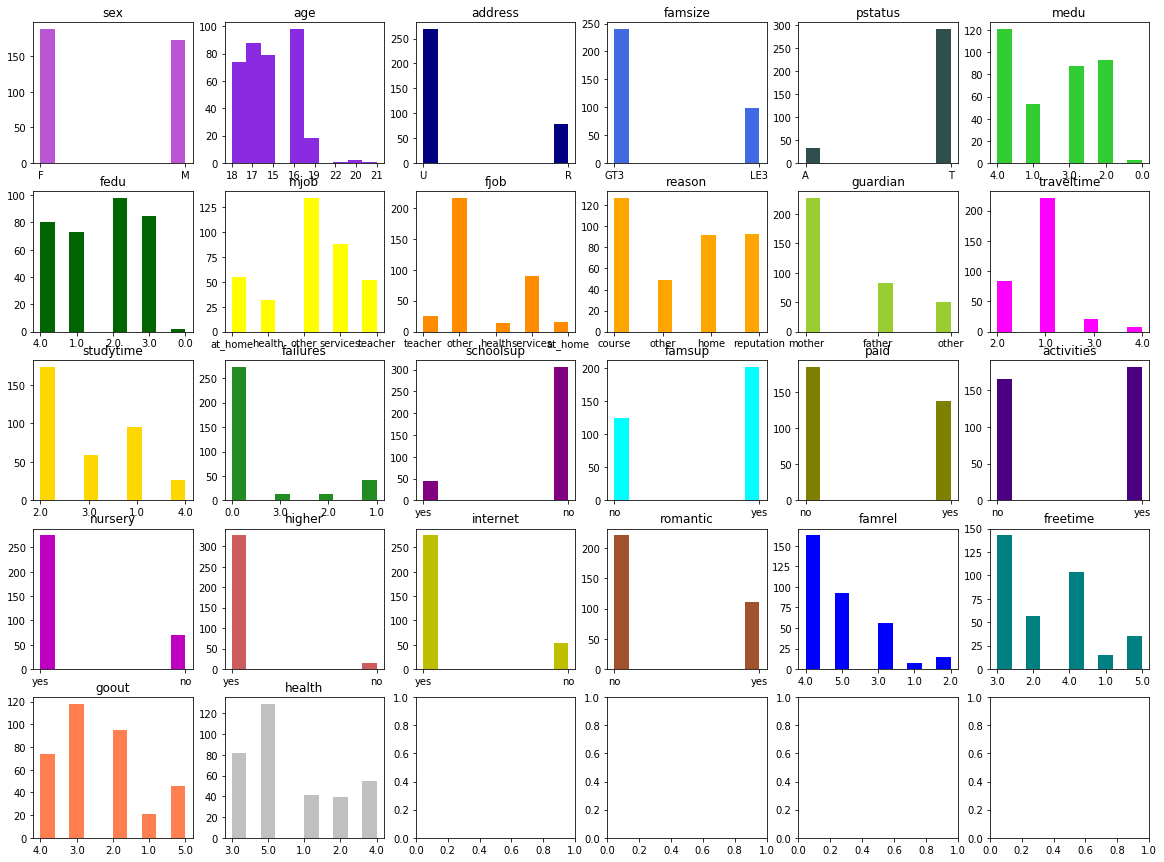

In [52]:
fig, pl = plt.subplots(5, 6, figsize=(20, 15))
clr = ['mediumorchid', 'blueviolet', 'navy', 'royalblue', 'darkslategrey', 'limegreen'
       , 'darkgreen', 'yellow', 'darkorange', 'orange', 'yellowgreen', 'magenta'
       , 'gold', 'forestgreen', 'purple', 'aqua', 'olive', 'indigo'
       , 'm', 'indianred', 'y', 'sienna', 'b', 'teal'
       , 'coral', 'silver']
for ind, col in enumerate(fixval_columns):
    pl_row, pl_col = divmod(ind, 6)
    valid = column_rules[col]['valid']
    hist_series = students[col][students[col].str.lower().isin(valid)]
    pl[pl_row, pl_col].hist(hist_series, color=clr[ind])
    pl[pl_row, pl_col].set_title(col) 

Пройдем по остальным столбцам:

In [25]:
other_columns

['school', 'absences', 'score']

In [26]:
students['school'].value_counts()

GP    349
MS     46
Name: school, dtype: int64

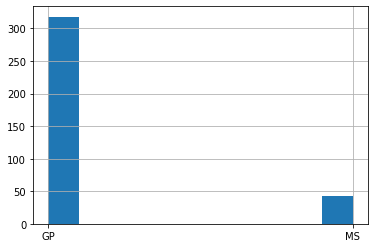

In [54]:
students['school'].hist()

С этой колонкой все впорядке. Следующая:

In [27]:
students['absences'].value_counts()

0.0      111
2.0       60
4.0       53
6.0       31
8.0       21
10.0      17
12.0      12
14.0      12
3.0        8
16.0       7
7.0        6
5.0        5
18.0       5
20.0       4
22.0       3
9.0        3
1.0        3
15.0       2
13.0       2
11.0       2
25.0       1
54.0       1
385.0      1
26.0       1
56.0       1
24.0       1
212.0      1
21.0       1
75.0       1
30.0       1
19.0       1
38.0       1
40.0       1
23.0       1
17.0       1
28.0       1
Name: absences, dtype: int64

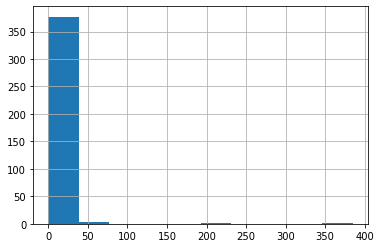

In [28]:
students['absences'].hist()

По графику видно, что есть какая то аномалия, проверим на выбросы:

In [29]:
median = students['absences'].median()
perc25 = students['absences'].quantile(0.25)
perc75 = students['absences'].quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


Здравый смысл подсказывает, что отрицательного количества отсутствия быть не может, сдвинем нижнюю границу до 0. Посмотрим, сколько строк попадают в эти границы:

In [44]:
sum(students['absences'].between(0, 20))

366

Оставим только эти строки:

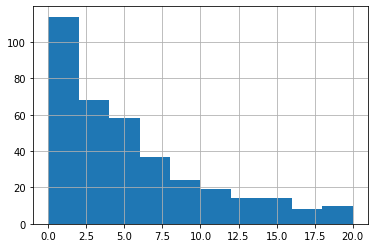

In [30]:
students = students[students['absences'].between(0, 20)]
students['absences'].hist()

Ну и наконец последний столбец с оценкой за экзамен. Проверим сразу есть ли значения вне диапазона допустимых (0, 100):

In [31]:
sum(~students['score'].between(0, 100))

5

Удалим эти строки, так как для анализа они бесполезны:

In [32]:
students = students[students['score'].between(0, 100)]

Посмотрим распределение:

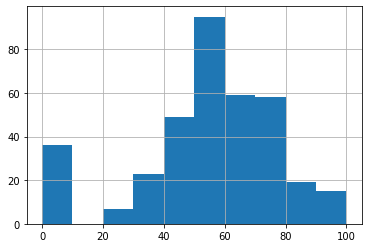

In [33]:
students['score'].hist()

В целом распределение нормальное, смущает только столбец графика слева. Проверим столбец данных на выбросы:

In [34]:
median = students['score'].median()
perc25 = students['score'].quantile(0.25)
perc75 = students['score'].quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


Выбросов нет! Наши данные готовы для дальнейшего анализа!

Построим матрицу корреляций для всех числовых столбцов, вернем колонке "age" числовой тип, так как это логичнее:

In [35]:
students.age = students.age.astype('int')
students.corr()

,age,absences,score
age,1.000000,0.155469,-0.159306
absences,0.155469,1.000000,0.081274
score,-0.159306,0.081274,1.000000


Между столбцами корреляций не обнаружено.

Соберем автоматически все нечисловые столбцы для анализа номинативных переменных:

In [37]:
box_columns = []
for col in students.columns:
    typ = students[col].dtype
    if typ == 'O':
        box_columns.append(col)
print(box_columns)

['school', 'sex', 'address', 'famsize', 'pstatus', 'medu', 'fedu', 'mjob', 'fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'health']


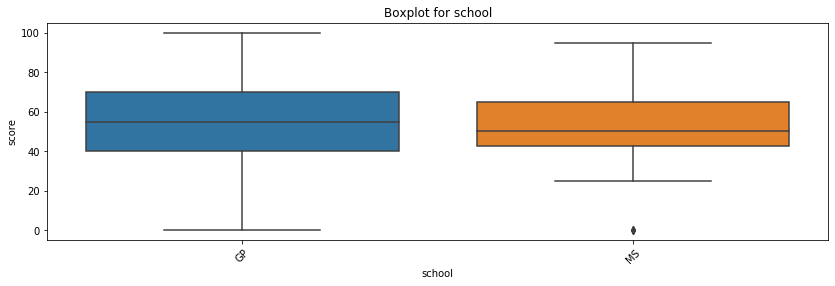

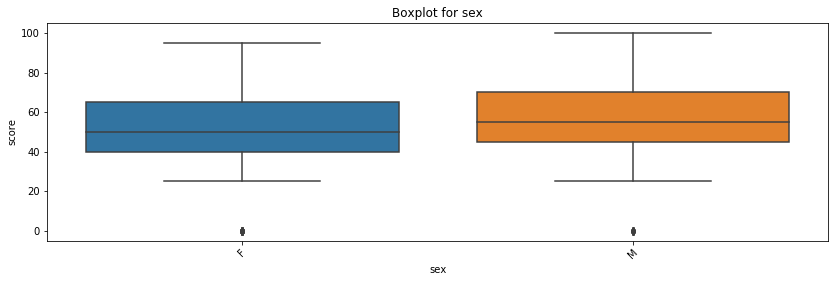

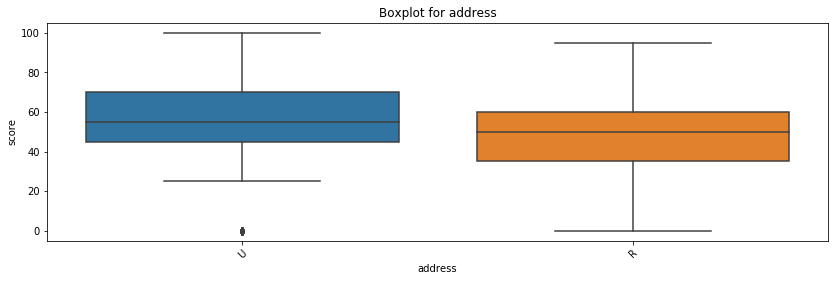

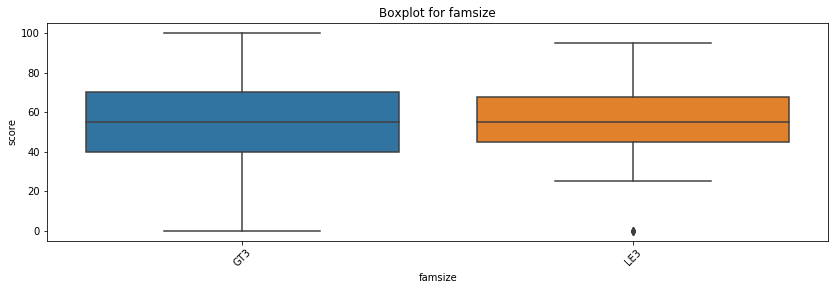

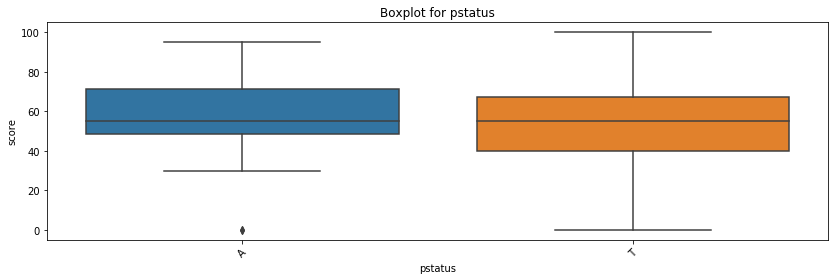

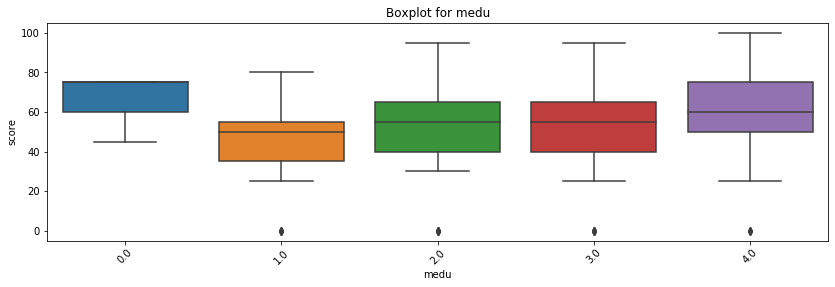

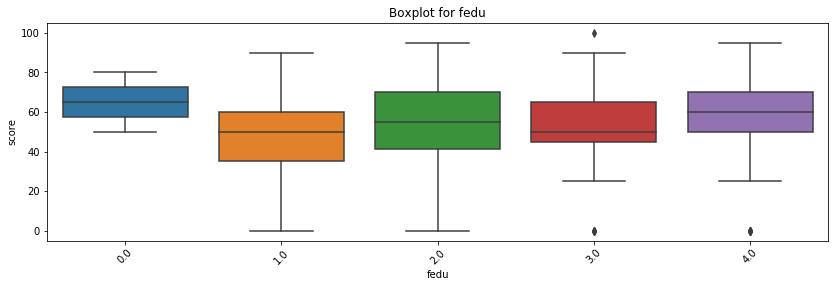

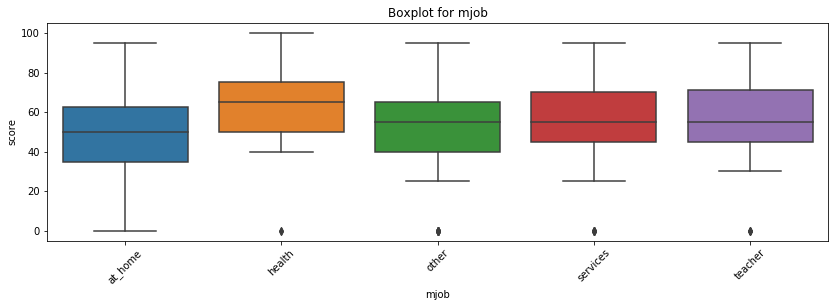

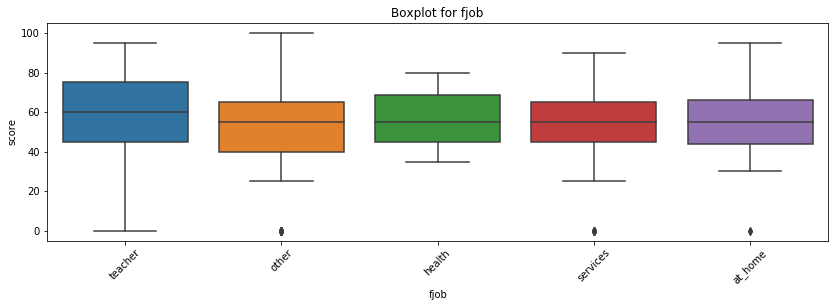

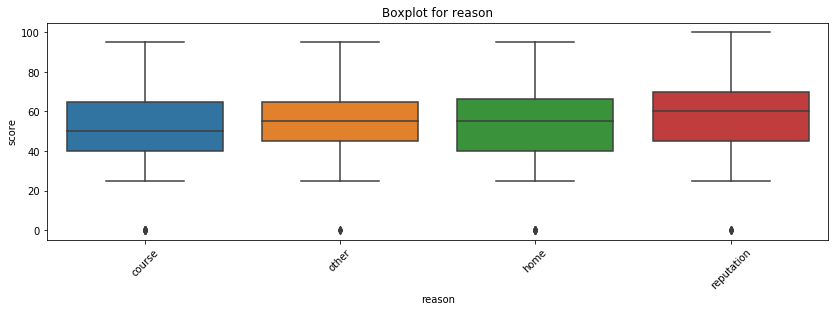

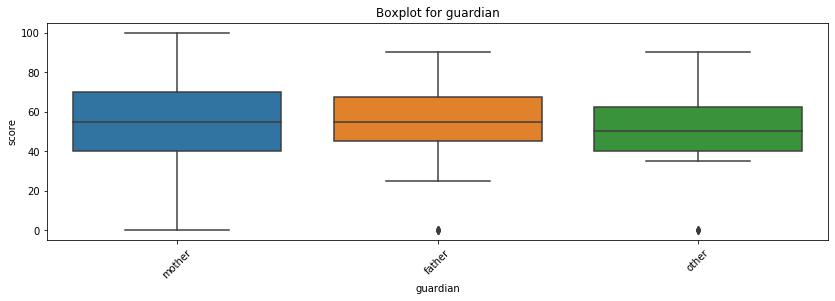

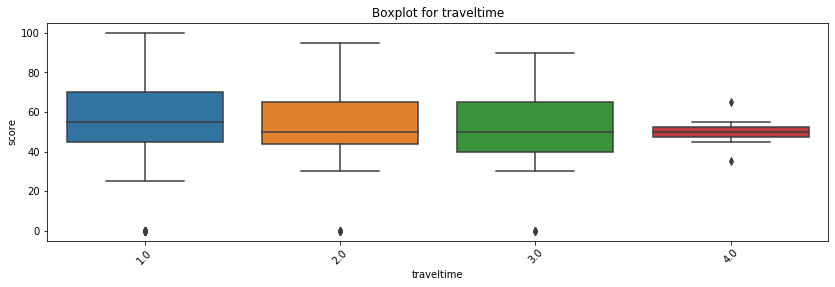

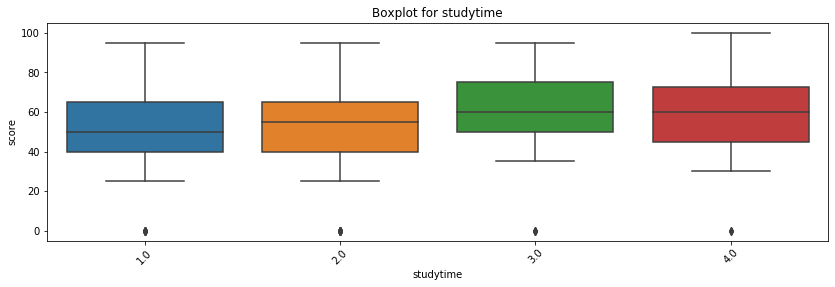

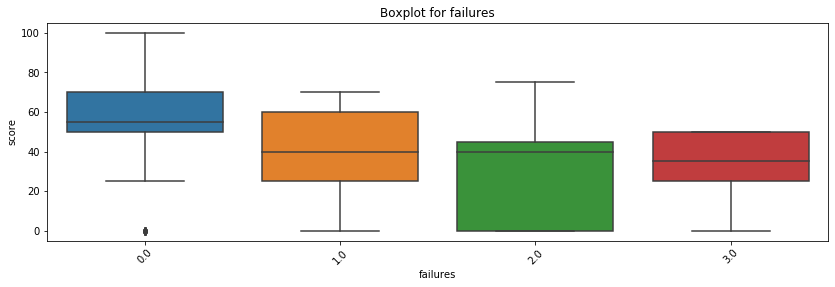

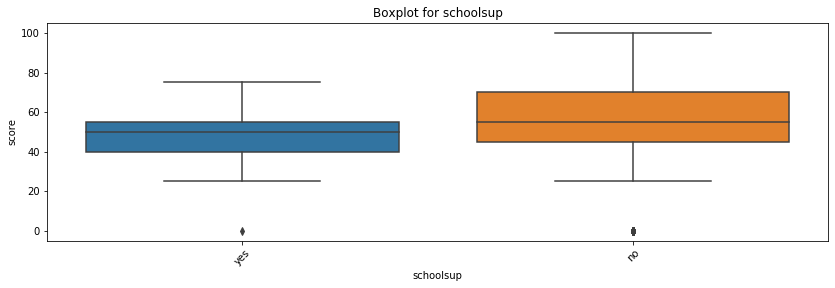

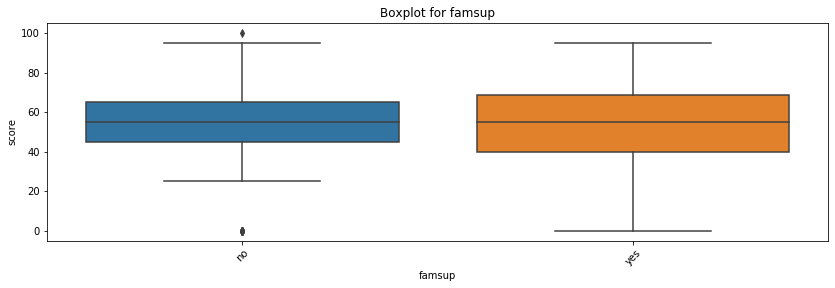

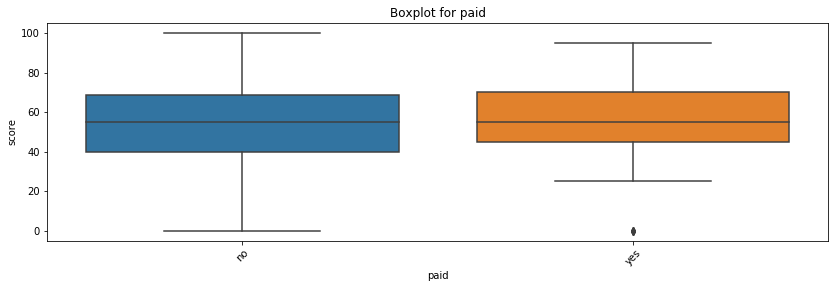

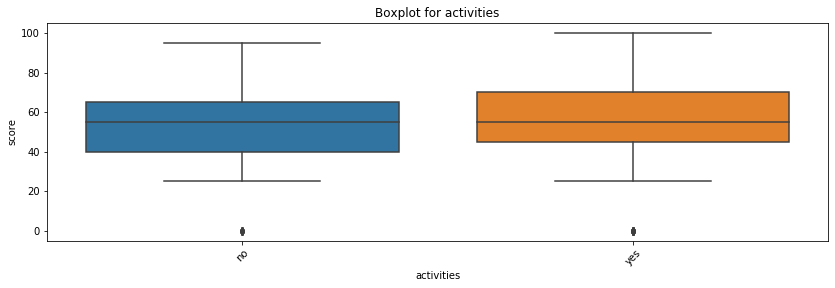

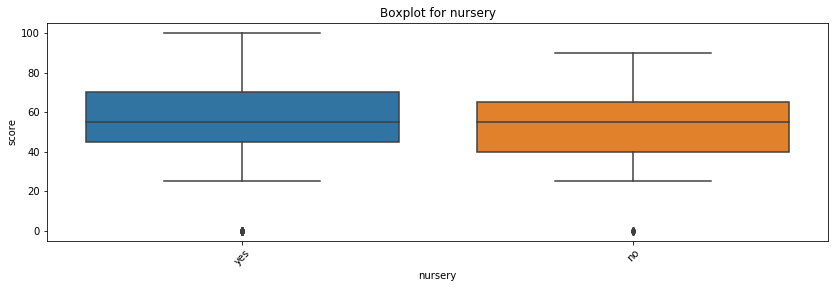

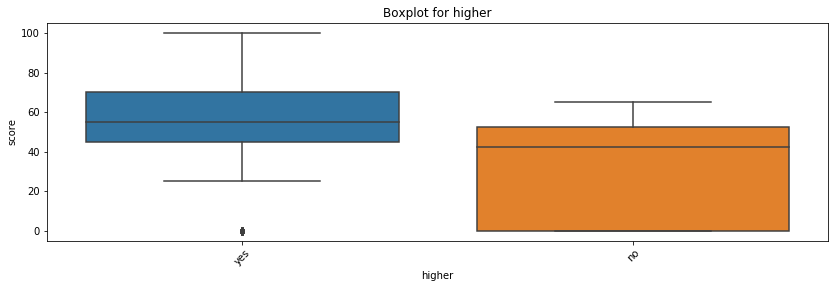

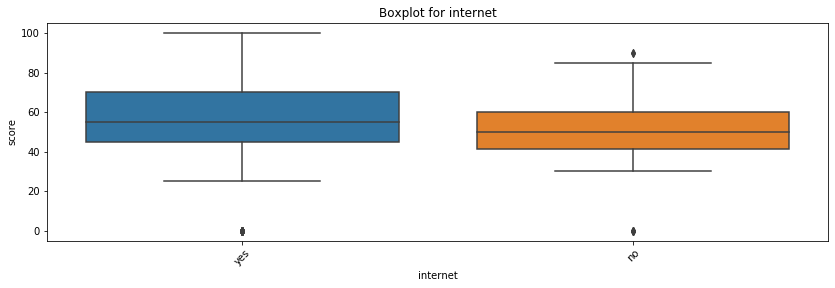

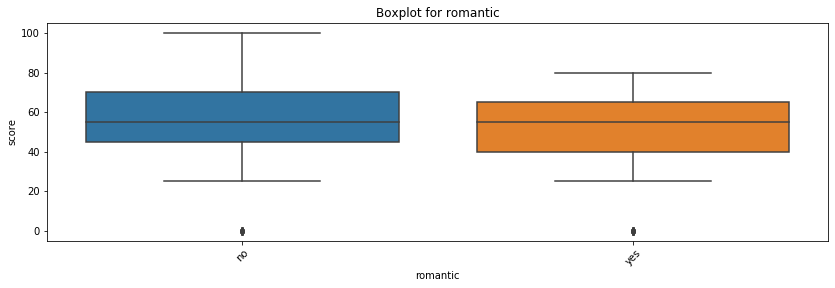

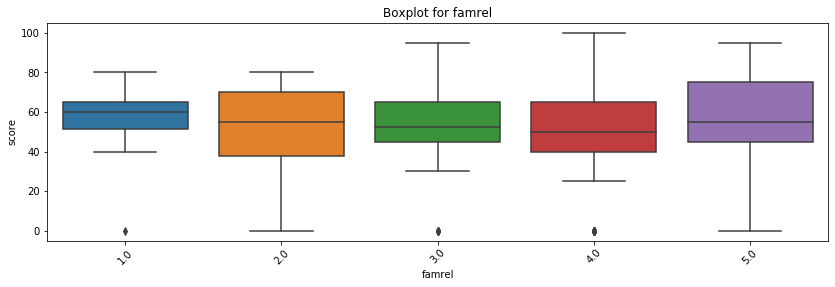

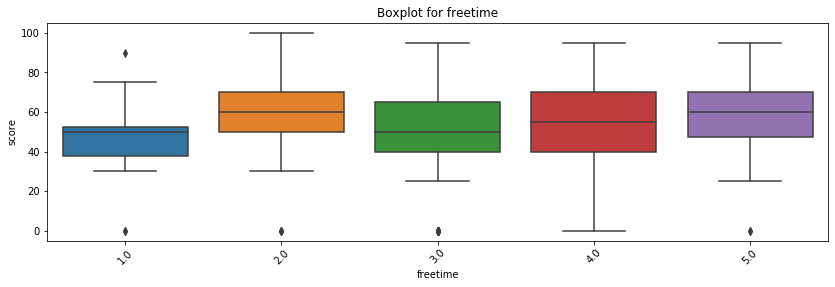

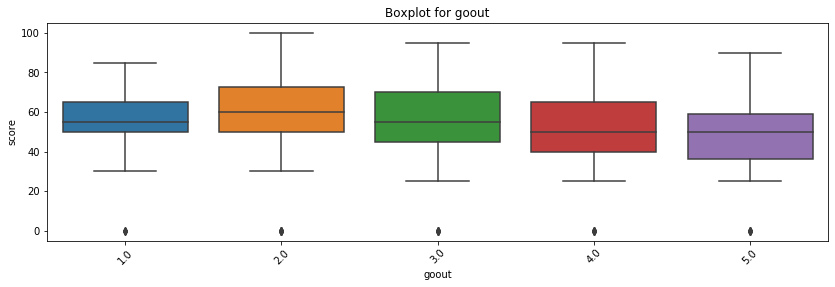

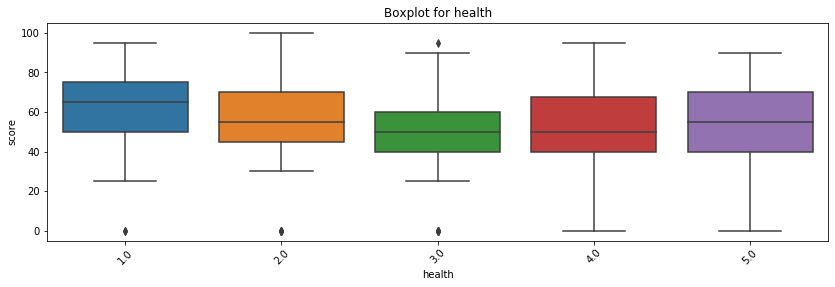

In [40]:
for col in box_columns:
    get_boxplot(col)

По визуальному осмотру графиков мне показалось, что мало влияют на результат такие столбцы: пол, размер семьи, работа отца и матери, ходил ли ребенок в детский сад, есть ли у него романтические отношения и есть ли дополнительные внеучебные занятия. Исколючим из дальнейшего анализа все перечисленные колонки. Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения оценок по различным параметрам неразличимы:

In [50]:
for col in ('school', 'address', 'pstatus', 'medu', 'fedu', 'reason', 'guardian', 'traveltime'
            , 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'higher'
            , 'internet', 'famrel', 'freetime', 'goout', 'health'):
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки medu
Найдены статистически значимые различия для колонки failures
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher


Мы выяснили, какие признаки могут влиять на итоговую оценку, оставим только их:

In [45]:
students_for_model = students.loc[:, ['age', 'absences', 'address', 'medu', 'failures', 'paid', 'higher']]

Конец!